In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/pyspark/Stroke_Prediction

/content/gdrive/MyDrive/pyspark/Stroke_Prediction


In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pyspark.sql import SparkSession
import pyspark.sql as sparksql
import pyspark.sql.functions as f
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

In [5]:
spark = SparkSession.builder.getOrCreate()

In [6]:
df = spark.read.csv("/content/gdrive/MyDrive/pyspark/Stroke_Prediction/healthcare-dataset-stroke-data.csv",header=True)

# Eda

In [7]:
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

In [8]:
cat_col=["gender","ever_married","work_type","Residence_type","smoking_status"]
num_col=["age","hypertension","heart_disease","avg_glucose_level","bmi"]

In [9]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



In [10]:
df.dtypes

[('id', 'string'),
 ('gender', 'string'),
 ('age', 'string'),
 ('hypertension', 'string'),
 ('heart_disease', 'string'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'string'),
 ('bmi', 'string'),
 ('smoking_status', 'string'),
 ('stroke', 'string')]

In [11]:
# casting
df = df.withColumn("age",df.age.cast("int"))
df = df.withColumn("hypertension",df.hypertension.cast("int"))

df = df.withColumn("heart_disease",df.age.cast("int"))
df = df.withColumn("avg_glucose_level",df.hypertension.cast("float"))

df = df.withColumn("bmi",df.age.cast("int"))
df = df.withColumn("stroke",df.stroke.cast("int"))

In [12]:
df.toPandas().head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,67,Yes,Private,Urban,0.0,67,formerly smoked,1
1,51676,Female,61,0,61,Yes,Self-employed,Rural,0.0,61,never smoked,1
2,31112,Male,80,0,80,Yes,Private,Rural,0.0,80,never smoked,1
3,60182,Female,49,0,49,Yes,Private,Urban,0.0,49,smokes,1
4,1665,Female,79,1,79,Yes,Self-employed,Rural,1.0,79,never smoked,1


In [13]:
df.describe().show()

+-------+-----------------+------+------------------+------------------+------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|               age|      hypertension|     heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+------------------+------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|             5110|  5110|              5110|              5110|              5110|        5110|     5110|          5110|              5110|              5110|          5110|               5110|
|   mean|36517.82935420744|  null| 43.21526418786693|0.0974559686888454| 43.21526418786693|        null|     null|          null|0.0974559686888454| 43.21526418786693|          null| 0.048

In [14]:
df.select('gender').distinct().collect()

[Row(gender='Female'), Row(gender='Other'), Row(gender='Male')]

# Target Distribution

In [15]:
df.groupby('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



In [16]:
df.groupby('stroke').agg(
    (f.count('stroke')).alias('count'),
    (f.count('stroke') / df.count()).alias('percentage')*100
).show()

+------+-----+--------------------------------------------+
|stroke|count|((count(stroke) / 5110) AS percentage * 100)|
+------+-----+--------------------------------------------+
|     1|  249|                            4.87279843444227|
|     0| 4861|                           95.12720156555773|
+------+-----+--------------------------------------------+



From this we can see that it is a clearly imbalanced dataset, where the 95 % of target data belong to 1 class. So In this case mostly our Prediction model will be biased and inaccurate. 

There are different stratergies to handling it. We will look it later.

In [17]:
df.describe().show()

+-------+-----------------+------+------------------+------------------+------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|               age|      hypertension|     heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+------------------+------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|             5110|  5110|              5110|              5110|              5110|        5110|     5110|          5110|              5110|              5110|          5110|               5110|
|   mean|36517.82935420744|  null| 43.21526418786693|0.0974559686888454| 43.21526418786693|        null|     null|          null|0.0974559686888454| 43.21526418786693|          null| 0.048

In [18]:
# creating a temp view for eecuting sql queries

In [19]:
df.createOrReplaceTempView("data")

# checking influence of work type in Stroke

In [20]:
# query to find the number of in work type who have stroke
spark.sql('''SELECT work_type, COUNT(work_type) as work_type_count,
COUNT(work_type) *100 / (
SELECT count(work_type) from data WHERE stroke == 1
)

 FROM data WHERE stroke == 1 GROUP BY work_type ORDER BY COUNT(work_type) DESC''').show()



+-------------+---------------+---------------------------------------------+
|    work_type|work_type_count|((count(work_type) * 100) / scalarsubquery())|
+-------------+---------------+---------------------------------------------+
|      Private|            149|                            59.83935742971887|
|Self-employed|             65|                           26.104417670682732|
|     Govt_job|             33|                            13.25301204819277|
|     children|              2|                           0.8032128514056225|
+-------------+---------------+---------------------------------------------+



In [21]:
# query to find the number of in work type who have not stroke
spark.sql('''SELECT work_type, COUNT(work_type) as work_type_count,
COUNT(work_type) *100 / (
SELECT count(work_type) from data WHERE stroke == 0
)

 FROM data WHERE stroke == 0 GROUP BY work_type ORDER BY COUNT(work_type) DESC''').show()



+-------------+---------------+---------------------------------------------+
|    work_type|work_type_count|((count(work_type) * 100) / scalarsubquery())|
+-------------+---------------+---------------------------------------------+
|      Private|           2776|                            57.10759103065213|
|Self-employed|            754|                            15.51121168483851|
|     children|            685|                            14.09175066858671|
|     Govt_job|            624|                           12.836864842624975|
| Never_worked|             22|                          0.45258177329767535|
+-------------+---------------+---------------------------------------------+



In [22]:
spark.sql('''SELECT work_type, COUNT(work_type) as work_type_count,

COUNT(work_type) *100 / (
SELECT count(work_type) from data 
)

 FROM data 
WHERE stroke == 0 GROUP BY work_type 
ORDER BY COUNT(work_type) DESC''').show()

+-------------+---------------+---------------------------------------------+
|    work_type|work_type_count|((count(work_type) * 100) / scalarsubquery())|
+-------------+---------------+---------------------------------------------+
|      Private|           2776|                           54.324853228962816|
|Self-employed|            754|                           14.755381604696673|
|     children|            685|                           13.405088062622308|
|     Govt_job|            624|                           12.211350293542074|
| Never_worked|             22|                          0.43052837573385516|
+-------------+---------------+---------------------------------------------+



from this we can say that Most People who get stroke are having work type Private anD self-Employed

# Gender with Target

In [23]:
df_gen=spark.sql('''select gender , count(gender) as gender_count, 
count(gender)  / (select count(gender) 
from data where stroke==1)*100 as percentage from data
where stroke==1  group by gender''').toPandas()

In [24]:
df_gen

,gender,gender_count,percentage
0,Female,141,56.626506
1,Male,108,43.373494


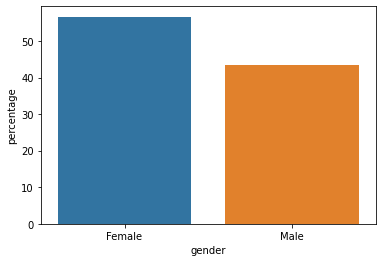

In [25]:
sns.barplot(data=df_gen, x="gender", y="percentage" )

In [26]:
df.show(1)

+----+------+---+------------+-------------+------------+---------+--------------+-----------------+---+---------------+------+
|  id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|
+----+------+---+------------+-------------+------------+---------+--------------+-----------------+---+---------------+------+
|9046|  Male| 67|           0|           67|         Yes|  Private|         Urban|              0.0| 67|formerly smoked|     1|
+----+------+---+------------+-------------+------------+---------+--------------+-----------------+---+---------------+------+
only showing top 1 row



# Checking the influence of Stroke after age 50

In [27]:
spark.sql('''select count(age) *100 / (select count(age) from data where stroke==1)as percentage
from data where stroke== 1 and age >=50 ''').show()

+-----------------+
|       percentage|
+-----------------+
|91.96787148594377|
+-----------------+



from here we can see that after age 50 91% people are having a chance of getting stroke

In [28]:
df.describe().show()

+-------+-----------------+------+------------------+------------------+------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|               age|      hypertension|     heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+------------------+------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|             5110|  5110|              5110|              5110|              5110|        5110|     5110|          5110|              5110|              5110|          5110|               5110|
|   mean|36517.82935420744|  null| 43.21526418786693|0.0974559686888454| 43.21526418786693|        null|     null|          null|0.0974559686888454| 43.21526418786693|          null| 0.048

In [29]:

# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            col(c).contains('N/A') | \
                            
                            col(c).contains('Unknown') | \

                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|          1544|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



# filling Missing Values

In [30]:
df.count()

5110

In [31]:
df=df.replace(['Unknown','N/A'],None)


df.show(

In [32]:
# for cat column weare fillinf them bu mode

In [33]:
sm_mode=df.groupby("smoking_status").count().orderBy("count", ascending=False).first()[0]

In [34]:
df.show(5)

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
| 9046|  Male| 67|           0|           67|         Yes|      Private|         Urban|              0.0| 67|formerly smoked|     1|
|51676|Female| 61|           0|           61|         Yes|Self-employed|         Rural|              0.0| 61|   never smoked|     1|
|31112|  Male| 80|           0|           80|         Yes|      Private|         Rural|              0.0| 80|   never smoked|     1|
|60182|Female| 49|           0|           49|         Yes|      Private|         Urban|              0.0| 49|         smokes|     1|
| 1665|Female| 79|           1|           79|         Yes|Self-employ

In [35]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: float (nullable = true)
 |-- bmi: integer (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [36]:
mean_bmi=df.select(f.mean('bmi')).toPandas()["avg(bmi)"][0]

In [37]:
df=df.na.fill(value=sm_mode,subset=["smoking_status"])
df=df.na.fill(value=mean_bmi,subset=["bmi"])

In [38]:
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
| 9046|  Male| 67|           0|           67|         Yes|      Private|         Urban|              0.0| 67|formerly smoked|     1|
|51676|Female| 61|           0|           61|         Yes|Self-employed|         Rural|              0.0| 61|   never smoked|     1|
|31112|  Male| 80|           0|           80|         Yes|      Private|         Rural|              0.0| 80|   never smoked|     1|
|60182|Female| 49|           0|           49|         Yes|      Private|         Urban|              0.0| 49|         smokes|     1|
| 1665|Female| 79|           1|           79|         Yes|Self-employ

In [39]:
df = df.drop('id')

# Handling Categorical Columns

In [40]:
from pyspark.ml import Pipeline

In [41]:
cols= df.columns

In [42]:
df.show(5)

+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|
+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|  Male| 67|           0|           67|         Yes|      Private|         Urban|              0.0| 67|formerly smoked|     1|
|Female| 61|           0|           61|         Yes|Self-employed|         Rural|              0.0| 61|   never smoked|     1|
|  Male| 80|           0|           80|         Yes|      Private|         Rural|              0.0| 80|   never smoked|     1|
|Female| 49|           0|           49|         Yes|      Private|         Urban|              0.0| 49|         smokes|     1|
|Female| 79|           1|           79|         Yes|Self-employed|         Rural|              1.0| 79|   never

In [43]:
stages=[]

In [44]:
categoricalColumns = ["gender","ever_married", "work_type", "Residence_type","smoking_status"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols = ["age", "hypertension","heart_disease","avg_glucose_level","bmi"]
assemblerInputs= [c + "classVec" for c in categoricalColumns] + numericCols 
assembler = VectorAssembler(inputCols = assemblerInputs,outputCol="features")
stages += [assembler]
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_encoded = pipelineModel.transform(df)
selectCols = ['features'] + cols
df_encoded = df_encoded.select(selectCols)

In [45]:
df_encoded.show()

+--------------------+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|            features|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|
+--------------------+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|(15,[1,2,3,7,9,10...|  Male| 67|           0|           67|         Yes|      Private|         Urban|              0.0| 67|formerly smoked|     1|
|(15,[0,2,4,8,10,1...|Female| 61|           0|           61|         Yes|Self-employed|         Rural|              0.0| 61|   never smoked|     1|
|(15,[1,2,3,8,10,1...|  Male| 80|           0|           80|         Yes|      Private|         Rural|              0.0| 80|   never smoked|     1|
|(15,[0,2,3,7,10,1...|Female| 49|           0|           49|         Yes|      Private|         Urban|          

***bold text***

In [46]:
df_encoded.show()

+--------------------+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|            features|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|
+--------------------+------+---+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|(15,[1,2,3,7,9,10...|  Male| 67|           0|           67|         Yes|      Private|         Urban|              0.0| 67|formerly smoked|     1|
|(15,[0,2,4,8,10,1...|Female| 61|           0|           61|         Yes|Self-employed|         Rural|              0.0| 61|   never smoked|     1|
|(15,[1,2,3,8,10,1...|  Male| 80|           0|           80|         Yes|      Private|         Rural|              0.0| 80|   never smoked|     1|
|(15,[0,2,3,7,10,1...|Female| 49|           0|           49|         Yes|      Private|         Urban|          

# Train Test Split

In [47]:
train , test = df_encoded.randomSplit([0.70,0.30],seed=99)
print("There are %d training examples and %d test examples"%(train.count(), test.count()))

There are 3595 training examples and 1515 test examples


# Base Model

# Logistic Regression

In [48]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features',labelCol='stroke')
model_lr= lr.fit(train)
lr_pred = model_lr.transform(test)



Evaluation

In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
f1_eval= MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
prec_eval= MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedPrecision")
recall_eval= MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedRecall")




In [50]:
# Logistric Regression Evaluaion
lr_acc = acc_evaluator.evaluate(lr_pred)
lr_f1= f1_eval.evaluate(lr_pred)
lr_prec = prec_eval.evaluate(lr_pred)
lr_recall=recall_eval.evaluate(lr_pred)


print('Logistic Regression Accuracy: {0:2.2f}%'.format(lr_acc*100))
print('Logistic Regression F1 score of: {}'.format(lr_f1))
print('Logistic Regression Precision score : {}'.format(lr_prec))
print('Logistic Regression Recall score of: {}'.format(lr_recall))

Logistic Regression Accuracy: 95.51%
Logistic Regression F1 score of: 0.9331884842771921
Logistic Regression Precision score : 0.9122456404056247
Logistic Regression Recall score of: 0.9551155115511551


# Decision Tree

In [51]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'stroke')
dtModel = dt.fit(train)
dtPreds = dtModel.transform(test)
dtc_predictions = dtModel.transform(test)

In [52]:
# Logistric Regression Evaluaion
dt_acc = acc_evaluator.evaluate(dtc_predictions)
dt_f1= f1_eval.evaluate(dtc_predictions)
dt_prec = prec_eval.evaluate(dtc_predictions)
dt_recall=recall_eval.evaluate(dtc_predictions)


print('Decision Tree Accuracy: {0:2.2f}%'.format(dt_acc*100))
print('Decision Tree F1 score of: {}'.format(dt_f1))
print('Decision Tree Precision score : {}'.format(dt_prec))
print('Decision Tree Recall score of: {}'.format(dt_recall))

Decision Tree Accuracy: 95.25%
Decision Tree F1 score of: 0.931867263805488
Decision Tree Precision score : 0.9121321529902825
Decision Tree Recall score of: 0.9524752475247524


# Random Forest


In [53]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'stroke')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(test)


In [54]:
rf_acc = acc_evaluator.evaluate(rfPreds)
rf_f1= f1_eval.evaluate(rfPreds)
rf_prec = prec_eval.evaluate(rfPreds)
rf_recall=recall_eval.evaluate(rfPreds)


print('Random Forest Accuracy: {0:2.2f}%'.format(rf_acc*100))
print('Random Forest F1 score of: {}'.format(rf_f1))
print('Random Forest Precision score : {}'.format(rf_prec))
print('Random Forest Recall score of: {}'.format(rf_recall))

Random Forest Accuracy: 95.51%
Random Forest F1 score of: 0.9331884842771921
Random Forest Precision score : 0.9122456404056247
Random Forest Recall score of: 0.9551155115511551


# Gradient Boosting

In [55]:
from pyspark.ml.classification import GBTClassifier

In [56]:
gb = GBTClassifier(featuresCol = 'features', labelCol = 'stroke')
gbModel = gb.fit(train)
gbPreds = gbModel.transform(test)

In [57]:
gb_acc = acc_evaluator.evaluate(gbPreds)
gb_f1= f1_eval.evaluate(gbPreds)
gb_prec = prec_eval.evaluate(gbPreds)
gb_recall=recall_eval.evaluate(gbPreds)


print('Gradient Boosting Accuracy: {0:2.2f}%'.format(gb_acc*100))
print('Gradient Boosting F1 score of: {}'.format(gb_f1))
print('Gradient Boosting Precision score : {}'.format(gb_prec))
print('Gradient Recall score of: {}'.format(gb_recall))

Gradient Boosting Accuracy: 95.18%
Gradient Boosting F1 score of: 0.9315364001736663
Gradient Boosting Precision score : 0.9121036871899111
Gradient Recall score of: 0.9518151815181518


# Linear SVC

In [58]:
from pyspark.ml.classification import LinearSVC

In [59]:
svc = LinearSVC(featuresCol = 'features', labelCol = 'stroke')
svcModel = svc.fit(train)
svcPreds = svcModel.transform(test)

In [60]:
svc_acc = acc_evaluator.evaluate(svcPreds)
svc_f1= f1_eval.evaluate(svcPreds)
svc_prec = prec_eval.evaluate(svcPreds)
svc_recall=recall_eval.evaluate(svcPreds)


print('Linear SVC Accuracy: {0:2.2f}%'.format(svc_acc*100))
print('Linear SVC  F1 score of: {}'.format(svc_f1))
print('Linear SVC  Precision score : {}'.format(svc_prec))
print('Linear Recall score of: {}'.format(svc_recall))

Linear SVC Accuracy: 95.51%
Linear SVC  F1 score of: 0.9331884842771921
Linear SVC  Precision score : 0.9122456404056247
Linear Recall score of: 0.9551155115511551


Our Dataset was imbalanced but we have applied 5 baseline machine algorithms and evaluated them and come to a conclusion that All Algorithms are performing we can similar accuracy but Random Forest and LInear Support Vector Machine did the best and did the tie.